In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. 讀檔（請確保能連網），或先手動下載到本地再調整路徑
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
df = pd.read_csv(url)


In [3]:
df.head(5)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [8]:
 # 檢查缺值並補值
# 先分資料型別：簡單的做法是以 object 類型視為 categorical，其餘視為 numerical
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
print("categorical:", cat_cols)
print("numerical:", num_cols)

# 缺值填 0
df = df.fillna(0)

# 切分
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.6/0.2/0.2

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

# DictVectorizer
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

categorical: ['origin', 'fuel_type', 'drivetrain']
numerical: ['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight', 'acceleration', 'model_year', 'num_doors', 'fuel_efficiency_mpg']


# Question 1 — Decision Tree (max_depth=1)
Let's train a decision tree regressor to predict the `fuel_efficiency_mpg` variable.

In [10]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)


,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [11]:
list(zip(dv.feature_names_, dt.feature_importances_))


[('acceleration', np.float64(0.0)),
 ('drivetrain=All-wheel drive', np.float64(0.0)),
 ('drivetrain=Front-wheel drive', np.float64(0.0)),
 ('engine_displacement', np.float64(0.0)),
 ('fuel_type=Diesel', np.float64(0.0)),
 ('fuel_type=Gasoline', np.float64(0.0)),
 ('horsepower', np.float64(0.0)),
 ('model_year', np.float64(0.0)),
 ('num_cylinders', np.float64(0.0)),
 ('num_doors', np.float64(0.0)),
 ('origin=Asia', np.float64(0.0)),
 ('origin=Europe', np.float64(0.0)),
 ('origin=USA', np.float64(0.0)),
 ('vehicle_weight', np.float64(1.0))]

# Question 2 — Random Forest (10 trees)
Train a random forest regressor with these parameters:

- `n_estimators`=10
- `random_state`=1
- `n_jobs`=-1 (optional - to make training faster)

What's the RMSE of this model on the validation data?

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)
print(rmse)


0.2112116828429789


# Question 3 — 找 n_estimators 之後 RMSE 不再改善的點


Now let's experiment with the `n_estimators` parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

After which value of `n_estimators` does RMSE stop improving? Consider 3 decimal places for calculating the answer.

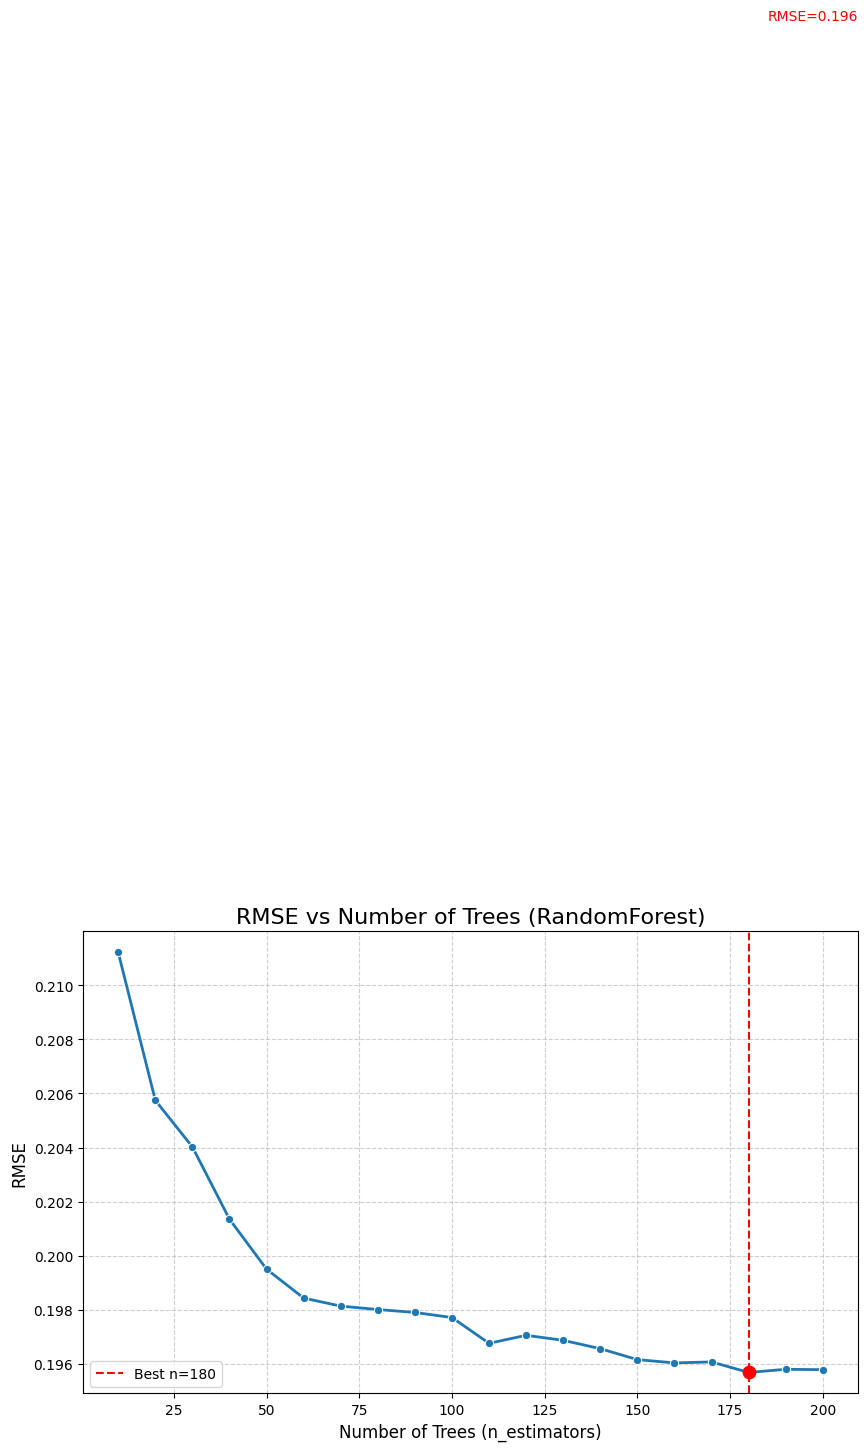

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

scores = []

for n in range(10, 210, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)
    scores.append((n, rmse))

# 轉成 DataFrame
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

# 顯示最佳點
best_n = df_scores.loc[df_scores['rmse'].idxmin(), 'n_estimators']
best_rmse = df_scores['rmse'].min()

# 繪圖
plt.figure(figsize=(10,6))
sns.lineplot(data=df_scores, x='n_estimators', y='rmse', marker='o', linewidth=2)
plt.title("RMSE vs Number of Trees (RandomForest)", fontsize=16)
plt.xlabel("Number of Trees (n_estimators)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# 標註最佳點
plt.axvline(best_n, color='r', linestyle='--', label=f'Best n={best_n}')
plt.scatter(best_n, best_rmse, color='red', s=80, zorder=5)
plt.text(best_n+5, best_rmse+0.05, f"RMSE={best_rmse:.3f}", color='red')

plt.legend()
plt.show()


# Question 4 — 不同 max_depth 的平均 RMSE

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values,
    - try different values of n_estimators from 10 till 200 (with step 10)
    - calculate the mean RMSE
- Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

max_depth
10    0.195201
15    0.198412
20    0.199159
25    0.198855
Name: rmse, dtype: float64
✅ Best max_depth: 10


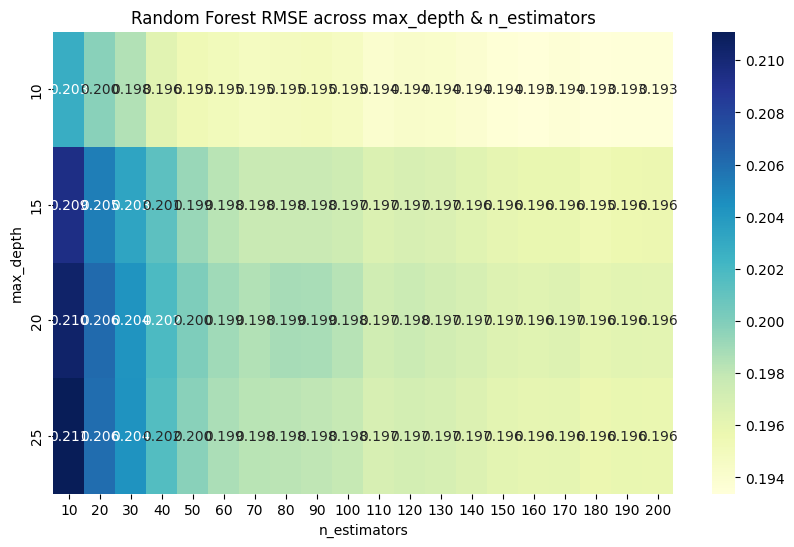

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

max_depth_values = [10, 15, 20, 25]
n_estimators_values = range(10, 210, 10)

results = []

for depth in max_depth_values:
    for n in n_estimators_values:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=depth,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred)  # 計算 RMSE
        results.append((depth, n, rmse))

# 轉成 DataFrame
df_scores = pd.DataFrame(results, columns=['max_depth', 'n_estimators', 'rmse'])

# 計算每個 max_depth 的平均 RMSE
avg_rmse = df_scores.groupby('max_depth')['rmse'].mean()
print(avg_rmse)

# 找出最佳 max_depth
best_depth = avg_rmse.idxmin()
print(f"✅ Best max_depth: {best_depth}")

# --- 動態熱圖顯示 ---
plt.figure(figsize=(10, 6))
pivot_table = df_scores.pivot(index='max_depth', columns='n_estimators', values='rmse')

sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Random Forest RMSE across max_depth & n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()


# Question 5 — 特徵重要性

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parameters:
    - `n_estimators`=10,
    - `max_depth`=20,
    - `random_state`=1,
    - `n_jobs`=-1 (optional)
- Get the feature importance information from this model


What's the most important feature (among these 4)?


In [23]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
dict(zip(dv.feature_names_, importances))


{'acceleration': np.float64(0.01147970063142938),
 'drivetrain=All-wheel drive': np.float64(0.0003571085493021933),
 'drivetrain=Front-wheel drive': np.float64(0.00034538411263183535),
 'engine_displacement': np.float64(0.0032727919136094864),
 'fuel_type=Diesel': np.float64(0.000325424322869738),
 'fuel_type=Gasoline': np.float64(0.00036038360069172865),
 'horsepower': np.float64(0.015997897714266237),
 'model_year': np.float64(0.003212300094794675),
 'num_cylinders': np.float64(0.0023433469524512048),
 'num_doors': np.float64(0.0016349895439306998),
 'origin=Asia': np.float64(0.0004622464955097423),
 'origin=Europe': np.float64(0.000518739638586969),
 'origin=USA': np.float64(0.0005397216891829147),
 'vehicle_weight': np.float64(0.9591499647407432)}

# Question 6 — XGBoost eta 調整

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```json
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

```

Now change `eta` from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [26]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 1.5 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 4.9 MB/s eta 0:00:0000:0100:02

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [29]:
import xgboost as xgb

# 將 numpy.ndarray 轉成 Python list
features = list(dv.get_feature_names_out())

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]


### Case 1: eta = 0.3

In [30]:
xgb_params = {'eta': 0.3, 'max_depth': 6, 'min_child_weight': 1,
              'objective': 'reg:squarederror', 'seed': 1, 'nthread': 8, 'verbosity': 0}
model_03 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)


### Case 2: eta = 0.1

In [31]:
xgb_params['eta'] = 0.1
model_01 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)


In [33]:

# 5️⃣ 用 validation 計算 RMSE
y_pred_03 = model_03.predict(dval)
y_pred_01 = model_01.predict(dval)

rmse_03 = mean_squared_error(y_val, y_pred_03)
rmse_01 = mean_squared_error(y_val, y_pred_01)

print(f"eta=0.3 RMSE: {rmse_03:.4f}")
print(f"eta=0.1 RMSE: {rmse_01:.4f}")

# 6️⃣ 判斷哪個 eta 表現最好
best_eta = 0.3 if rmse_03 < rmse_01 else 0.1 if rmse_01 < rmse_03 else "Both give equal value"
print("Best eta:", best_eta)

eta=0.3 RMSE: 0.2027
eta=0.1 RMSE: 0.1817
Best eta: 0.1
